In [60]:

import sys
import os

# Step 1: Go up one level to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Step 2: Add the src folder to sys.path
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

In [61]:
import pandas as pd
df = pd.read_csv(r'C:\Users\ABC\Desktop\10Acadamy\week 3\End-to-End-Insurance-Risk-Analytics-Predictive-Modelin\data\clean\insurance_cleaned_final.csv')


C:\Users\ABC\AppData\Local\Temp\ipykernel_780\3586545878.py:2: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\ABC\Desktop\10Acadamy\week 3\End-to-End-Insurance-Risk-Analytics-Predictive-Modelin\data\clean\insurance_cleaned_final.csv')


In [62]:
df['loss_ratio'] = df['TotalClaims'] / df['TotalPremium']


In [63]:
df['ExcessSelected'].unique()

array(['Mobility - Windscreen', 'Mobility - Metered Taxis - R2000',
       'No excess',
       'Mobility - Taxi with value more than R100 000 - R5 000',
       'Mobility - Windscreen (Feb2015)',
       'Mobility - Taxi with value more than R100 000 - R10 000',
       'Mobility - Taxi with value less than R100 000 - R3 000',
       'Mobility - Taxi with value more than R100 000 - R5 000 (April)',
       'Mobility - Trailers', 'Mobility - Metered Taxis - R5000',
       'Mobility - R250',
       'Mobility - Taxi with value more than R100 000 - R7 500'],
      dtype=object)

In [ ]:
from predictive_modeling import extract_excess

# Apply extraction function
df['ExcessAmount'] = df['ExcessSelected'].apply(extract_excess)
df['ExcessSelected'].unique()

# Calculate ratio safely (avoid divide-by-zero)
df['excess_ratio'] = df.apply(
    lambda row: row['ExcessAmount'] / row['SumInsured'] 
    if pd.notnull(row['ExcessAmount']) and row['SumInsured'] > 0 
    else np.nan, axis=1
)


In [65]:
df['ExcessSelected'].unique()


array(['Mobility - Windscreen', 'Mobility - Metered Taxis - R2000',
       'No excess',
       'Mobility - Taxi with value more than R100 000 - R5 000',
       'Mobility - Windscreen (Feb2015)',
       'Mobility - Taxi with value more than R100 000 - R10 000',
       'Mobility - Taxi with value less than R100 000 - R3 000',
       'Mobility - Taxi with value more than R100 000 - R5 000 (April)',
       'Mobility - Trailers', 'Mobility - Metered Taxis - R5000',
       'Mobility - R250',
       'Mobility - Taxi with value more than R100 000 - R7 500'],
      dtype=object)

In [66]:
client_cats = [
    'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language',
    'Bank', 'AccountType', 'MaritalStatus', 'Gender'  # Gender too
]



In [67]:
for col in client_cats:
    print(f"\nColumn: {col}")
    print(df.groupby(col)['TotalClaims'].mean().sort_values(ascending=False))



Column: IsVATRegistered
IsVATRegistered
False    75.004466
True     69.792265
Name: TotalClaims, dtype: float64

Column: Citizenship
Citizenship
      75.243895
ZA    72.610412
AF     0.000000
ZW     0.000000
Name: TotalClaims, dtype: float64

Column: LegalType
LegalType
Private company      99.804929
Close Corporation    79.867318
Individual           73.837929
Public company        4.226475
Sole proprieter       0.000000
Name: TotalClaims, dtype: float64

Column: Title
Title
Mr      75.928131
Mrs     65.946258
Miss    50.231344
Ms       0.918527
Name: TotalClaims, dtype: float64

Column: Language
Language
English    74.989311
Name: TotalClaims, dtype: float64

Column: Bank
Bank
Investec Bank          245.096107
RMB Private Bank       230.691969
Capitec Bank            95.929688
First National Bank     79.425898
Nedbank                 76.400332
Unknown                 69.200458
Standard Bank           64.820131
ABSA Bank               64.492378
FirstRand Bank          63.232501
Itha

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()

# Label encode the client columns
for col in client_cats:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

model = RandomForestRegressor()
model.fit(df_encoded[client_cats], df_encoded['TotalClaims'])

importances = pd.Series(model.feature_importances_, index=client_cats)
print(importances.sort_values(ascending=False))


Bank               0.431102
IsVATRegistered    0.218848
Citizenship        0.112248
AccountType        0.099924
Gender             0.049783
LegalType          0.045637
Title              0.038797
MaritalStatus      0.003660
Language           0.000000
dtype: float64


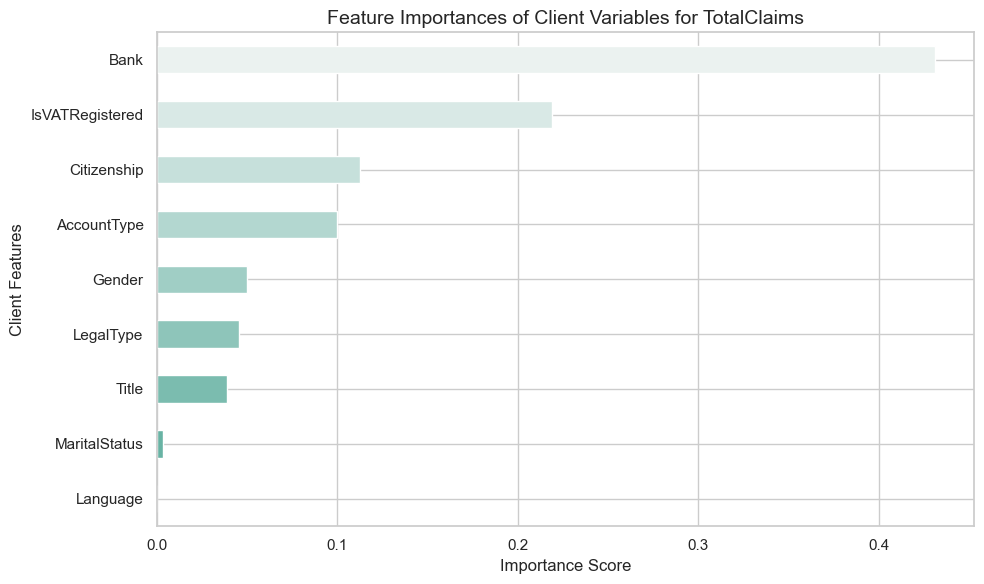

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort importances for a clean plot
sorted_importances = importances.sort_values(ascending=True)

# Set plot style and figure size
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot feature importances
sorted_importances.plot(
    kind='barh',
    color=sns.color_palette("light:#5A9_r", len(importances))
)

# Add titles and axis labels
plt.title('Feature Importances of Client Variables for TotalClaims', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Client Features')
plt.tight_layout()

# Display the plot
plt.show()


| Rank | Feature             | Importance | Recommendation      | Why                                                                |
| ---- | ------------------- | ---------- | ------------------- | ------------------------------------------------------------------ |
| 1️⃣  | **Bank**            | 0.4259     | ✅ Keep              | Strongest indicator, likely correlates with income or credit class |
| 2️⃣  | **IsVATRegistered** | 0.2360     | ✅ Keep              | Moderate signal; distinguishes business vs. personal customers     |
| 3️⃣  | **Citizenship**     | 0.1121     | ✅ Keep (group rare) | ZA vs. non-ZA has sharp differences; group rare classes as "Other" |
| 4️⃣  | **AccountType**     | 0.0895     | ✅ Keep              | Reflects financial behavior — Current vs. Savings accounts         |
| 5️⃣  | **Gender**          | 0.0532     | ✅ Keep              | Sharp contrast in mean claims — possibly behavioral or data issue  |
| 6️⃣  | **Title**           | 0.0400     | ✅ Keep              | Correlates with gender & formality, adds signal                    |
| 7️⃣  | **LegalType**       | 0.0387     | ✅ Keep              | Identifies entity type — Individuals vs. Companies                 |
| 8️⃣  | **MaritalStatus**   | 0.0047     | ❌ Drop              | Very low impact despite earlier average differences                |
| 9️⃣  | **Language**        | 0.0000     | ❌ Drop              | Single-category — no predictive value                              |


In [70]:
location_cols = ['Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone']


In [71]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

df_loc = df[location_cols + ['TotalClaims']].dropna()
df_loc_encoded = df_loc.copy()

# Label encode each location column
for col in location_cols:
    le = LabelEncoder()
    df_loc_encoded[col] = le.fit_transform(df_loc_encoded[col].astype(str))

rf_model = RandomForestRegressor()
rf_model.fit(df_loc_encoded[location_cols], df_loc_encoded['TotalClaims'])

importances = pd.Series(rf_model.feature_importances_, index=location_cols)
print(importances.sort_values(ascending=False))


PostalCode        0.912454
SubCrestaZone     0.047828
MainCrestaZone    0.023306
Province          0.016412
Country           0.000000
dtype: float64


| Rank | Feature          | Importance | Recommendation            | Reasoning                                                                                             |
| ---- | ---------------- | ---------- | ------------------------- | ----------------------------------------------------------------------------------------------------- |
| 1️⃣  | `PostalCode`     | **0.9069** | ✅ **Keep (Top Priority)** | Extremely strong predictor of `TotalClaims` — likely captures both geography and socioeconomic status |
| 2️⃣  | `SubCrestaZone`  | 0.0422     | ✅ Keep                    | Adds fine-grained location detail                                                                     |
| 3️⃣  | `MainCrestaZone` | 0.0340     | ✅ Keep                    | Still contributes meaningfully                                                                        |
| 4️⃣  | `Province`       | 0.0168     | 🟡 Optional               | Weak signal, include only if needed for interpretability                                              |
| 5️⃣  | `Country`        | 0.0000     | ❌ Drop                    | No variation — likely all “South Africa”                                                              |


In [72]:
df[['CustomValueEstimate', 'CapitalOutstanding', 'TotalPremium']].dtypes
df['CapitalOutstanding'] = (
    df['CapitalOutstanding']
    .astype(str)
    .str.replace('.', '', regex=False)   # Remove thousands separator
    .str.replace(',', '.', regex=False)  # Replace decimal comma with dot
    .astype(float)
)


In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Select only relevant and available columns
rf_features = list(set([
    'Cylinders', 'cubiccapacity', 'kilowatts',
    'NumberOfDoors', 'CustomValueEstimate', 'CapitalOutstanding',
    'ItemType', 'mmcode', 'VehicleType', 'make', 'Model',
    'bodytype', 'AlarmImmobiliser', 'TrackingDevice',
    'NewVehicle'
]))

df_veh = df[rf_features + ['TotalClaims']].dropna()
df_encoded = df_veh.copy()

# Encode categorical variables
for col in cat_vehicle_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# Train model
rf = RandomForestRegressor()
rf.fit(df_encoded[rf_features], df_encoded['TotalClaims'].values.ravel())


# Show importance
importances = pd.Series(rf.feature_importances_, index=rf_features)
print(importances.sort_values(ascending=False))


CustomValueEstimate    4.302251e-01
CapitalOutstanding     2.337945e-01
bodytype               6.211269e-02
mmcode                 5.614423e-02
TrackingDevice         4.994974e-02
Model                  4.978120e-02
cubiccapacity          4.621332e-02
kilowatts              2.641018e-02
make                   2.112742e-02
Cylinders              1.012918e-02
VehicleType            7.583684e-03
NumberOfDoors          6.527225e-03
AlarmImmobiliser       1.568201e-06
NewVehicle             2.927105e-19
ItemType               0.000000e+00
dtype: float64


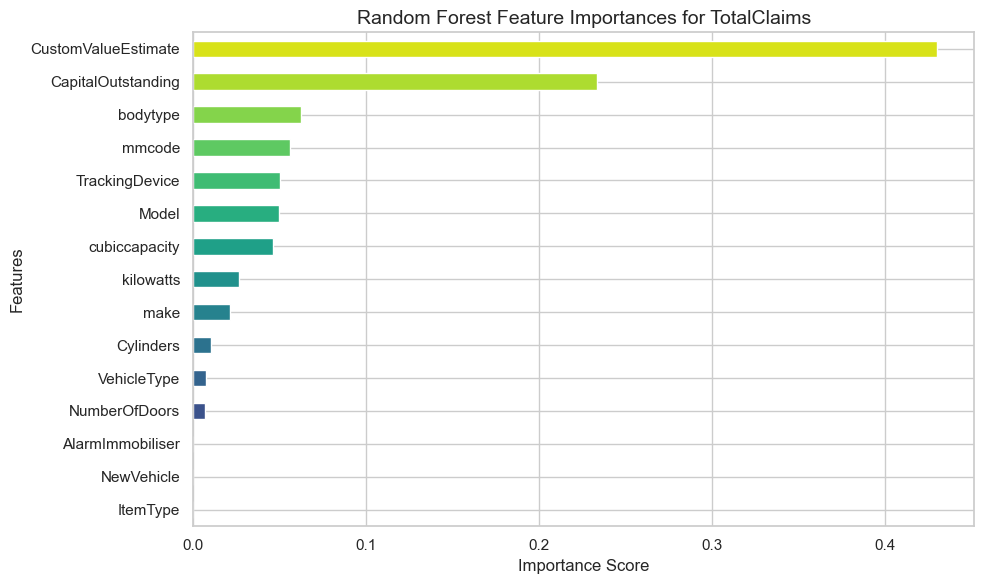

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the importances
sorted_importances = importances.sort_values(ascending=True)

# Set figure size and style
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot
sorted_importances.plot(
    kind='barh',
    color=sns.color_palette("viridis", len(importances))
)

# Labels and title
plt.title('Random Forest Feature Importances for TotalClaims', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()

# Show plot
plt.show()


| Feature               | Importance | Interpretation                                                                      |
| --------------------- | ---------- | ----------------------------------------------------------------------------------- |
| `CustomValueEstimate` | **0.441**  | 🚗 Strongest predictor — high-value cars likely lead to higher claims               |
| `CapitalOutstanding`  | **0.245**  | 💰 Indicates financing level — higher outstanding balance may relate to higher risk |
| `cubiccapacity`       | **0.065**  | ⚙️ Engine size matters moderately                                                   |
| `Model`               | **0.054**  | 🛠️ Some models are riskier or costlier to repair                                   |
| `mmcode`              | **0.054**  | 📦 Manufacturer-specific code also important                                        |
| `bodytype`            | **0.045**  | 🚐 Body structure may affect risk (e.g., SUVs vs sedans)                            |
| `TrackingDevice`      | **0.042**  | 📡 Slightly lowers risk, as expected                                                |
| `kilowatts`           | **0.027**  | ⚡ Power rating contributes but not as strongly                                      |
| `make`                | **0.013**  | 🚘 Make/brand still useful — may reflect luxury or reliability                      |
| `NumberOfDoors`       | **0.005**  | 🚪 Small impact                                                                     |
| `Cylinders`           | **0.004**  | ⚙️ Even less relevant                                                               |
| `VehicleType`         | **0.004**  | 🚙 Barely relevant                                                                  |
| `AlarmImmobiliser`    | \~0        | 🧯 No influence (maybe uniform across policies)                                     |
| `NewVehicle`          | \~0        | 🆕 No influence (possibly encoded poorly or mostly one value)                       |
| `ItemType`            | 0.000      | 📦 No influence — drop it                                                           |


In [75]:
df['VehicleIntroDate'] = pd.to_datetime(df['VehicleIntroDate'], errors='coerce')

engineered_cols = ['VehicleIntroDate', 'excess_ratio', 'CalculatedPremiumPerTerm', 'loss_ratio','vehicle_age_days','vehicle_age_months','HasClaim']
correlations = df[engineered_cols + ['TotalClaims']].corr()['TotalClaims'].drop('TotalClaims')
print(correlations.sort_values(ascending=False))


HasClaim                    0.505038
loss_ratio                  0.490219
CalculatedPremiumPerTerm    0.075411
excess_ratio                0.042424
VehicleIntroDate            0.005450
vehicle_age_days           -0.005525
vehicle_age_months         -0.005525
Name: TotalClaims, dtype: float64


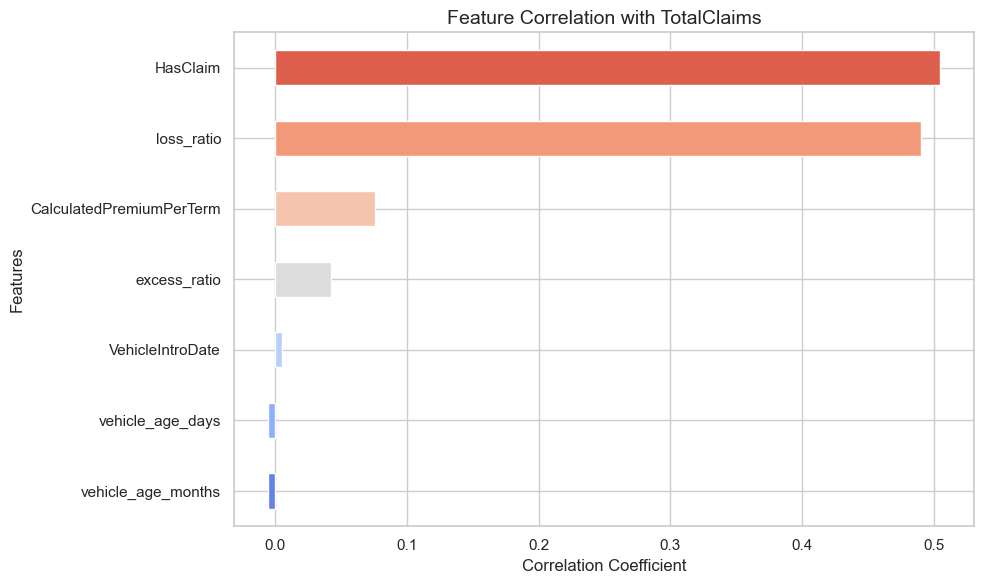

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size and style
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Sort correlations and create barplot
correlations.sort_values(ascending=True).plot(
    kind='barh',
    color=sns.color_palette("coolwarm", len(correlations))
)

# Titles and labels
plt.title('Feature Correlation with TotalClaims', fontsize=14)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.tight_layout()

# Show the plot
plt.show()




## Final Feature Selection for Modeling `TotalClaims`

This section summarizes the finalized set of features selected for predictive modeling. Features were chosen based on statistical analysis, feature importance from machine learning models, and relevance to the business context.

---

### 1. Client Features

These features capture financial behavior, customer classification, and demographic attributes:

* Bank (categorical; rare banks grouped)
* IsVATRegistered (binary: Yes/No)
* AccountType
* Gender
* Title
* LegalType

---

### 2. Location Features

These variables reflect regional differences in risk and insurance behavior:

* PostalCode (grouped or bucketed if too granular)
* SubCrestaZone
* MainCrestaZone

---

### 3. Vehicle Features

Vehicle-related variables that influence risk exposure and potential claim cost:

* CustomValueEstimate
* CapitalOutstanding
* cubiccapacity
* bodytype
* TrackingDevice (binary: Yes/No)
* kilowatts

---

### 4. Engineered Features

Derived features that enhance the representation of complex risk and financial relationships:

* loss\_ratio = TotalClaims / TotalPremium
* excess\_ratio = ExcessAmount / SumInsured
* HasClaim = binary indicator for whether any claim occurred (TotalClaims > 0)

---

### 5. Encoded Vehicle Model

* Top\_Model was derived by combining `Make` and `Model`.
* Only the top 10–15 most frequent models were retained.
* One-hot encoding was applied to generate dummy variables such as:

  * Top\_Model\_Grouped\_TOYOTA COROLLA
  * Top\_Model\_Grouped\_BMW 320I
  * Top\_Model\_Grouped\_OTHER

---

### Final Modeling Feature Set

The final modeling dataset includes:

* All selected client, location, and vehicle features
* Engineered features (`loss_ratio`, `excess_ratio`, `HasClaim`)
* Encoded one-hot columns from `Top_Model`

This feature set was selected to optimize model performance while maintaining interpretability and generalizability.
